In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 4.0 MB 14.8 MB/s 
     |████████████████████████████████| 1.2 MB 19.3 MB/s 
     |████████████████████████████████| 77 kB 2.3 MB/s 
     |████████████████████████████████| 596 kB 72.0 MB/s 
     |████████████████████████████████| 6.6 MB 65.0 MB/s 
     |████████████████████████████████| 880 kB 63.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=f2479bbcb180304b52b1964b6c4c0a035269612c083d19388efd6e1ae82352c7
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=783531164f95ed2cf6d2b55f63d2b3335585c64bb03246b441602eb51f1beaa6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str, num_purchases_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        num_purchases = torch.tensor([float(v) for v in num_purchases_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, num_purchases)
        
        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str, example_age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age),
            float(example_age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age, num_purchases, example_age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age, example_age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label, num_purchases)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [10]:
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model = SentenceTransformer('all-distilroberta-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [13]:
model.encode(article_descriptions[0]).shape

(768,)

In [14]:
embeddings = model.encode(article_descriptions)

In [15]:
embeddings = torch.tensor(embeddings)

In [16]:
embeddings.shape

torch.Size([40538, 768])

In [17]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [19]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+768+3, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [20]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [21]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=1155, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [22]:
BATCH_SIZE = 1024

In [23]:
total_training_examples = pd.read_csv('data/final_train_set.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

43.0

In [24]:
total_dev_examples = pd.read_csv('data/final_dev_set.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

9.0

In [25]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [105]:
MAX_EPOCHS = 150

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            # optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 0.9821499536660647


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 4.642381601166307


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 0.995559635040235


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 4.705765871416059


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 0.9933535131727199


100%|██████████| 9/9.0 [00:02<00:00,  3.38it/s]


Dev loss: 4.695338075202808


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 0.9866128170922768


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 4.663476460440117


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 0.9859104740538911


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 4.660156657402975


100%|██████████| 43/43.0 [00:11<00:00,  3.68it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 0.981871730312076


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 4.641066507707563


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 0.980543001204483


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 4.634785931570488


100%|██████████| 43/43.0 [00:11<00:00,  3.75it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 0.9834180212290774


100%|██████████| 9/9.0 [00:02<00:00,  3.16it/s]


Dev loss: 4.648375445081476


100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 0.98174189857553


100%|██████████| 9/9.0 [00:02<00:00,  3.23it/s]


Dev loss: 4.640452824977406


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 0.9836704411311529


100%|██████████| 9/9.0 [00:02<00:00,  3.41it/s]


Dev loss: 4.6495685719607165


100%|██████████| 43/43.0 [00:11<00:00,  3.84it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 0.9757285663653937


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 4.612029280578881


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 0.980019653906481


100%|██████████| 9/9.0 [00:02<00:00,  3.30it/s]


Dev loss: 4.632312197434275


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 0.9741459701635781


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 4.604548737040737


100%|██████████| 43/43.0 [00:11<00:00,  3.83it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 0.9729046725580818


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 4.5986814281396695


100%|██████████| 43/43.0 [00:11<00:00,  3.83it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 0.9783851506372235


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 4.624586301937438


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 0.9726953100293136


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 4.597691822888558


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 0.9720549603345676


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 4.594665047160366


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 0.9716254812429795


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 4.592635004980522


100%|██████████| 43/43.0 [00:11<00:00,  3.72it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 0.9735281361026557


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 4.601628387183474


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 0.968846154299231


100%|██████████| 9/9.0 [00:02<00:00,  3.38it/s]


Dev loss: 4.579497809159128


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 0.9744462764273109


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 4.6059682109899684


100%|██████████| 43/43.0 [00:11<00:00,  3.88it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 0.9694581162324474


100%|██████████| 9/9.0 [00:02<00:00,  3.30it/s]


Dev loss: 4.5823904029110025


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 0.9664810048280581


100%|██████████| 9/9.0 [00:02<00:00,  3.19it/s]


Dev loss: 4.5683183285228


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 0.9624752447491642


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 4.5493840845007645


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.45it/s]


Training loss: 0.9650395826892086


100%|██████████| 9/9.0 [00:02<00:00,  3.39it/s]

Dev loss: 4.561505080105966


In [106]:
training_losses[-1], dev_losses[-1]

(0.9650395826892086, 4.561505080105966)

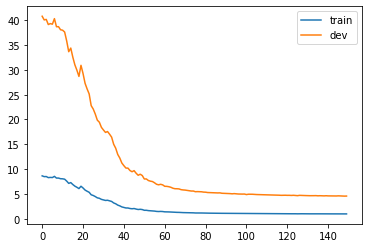

In [107]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [108]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 43/43.0 [00:10<00:00,  3.98it/s]


In [109]:
predictions = torch.concat(predictions)

In [110]:
predictions.shape

torch.Size([43108, 1000])

In [111]:
actuals = pd.read_csv('data/final_train_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [112]:
mapk(actuals, predictions.tolist(), 12)

0.9982893360797913

🤯

In [113]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [114]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

1.0

In [115]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [116]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

Model is a strong top-1000 candidate generator:
- 99+% precision
- Can use all customers in training set since each has at least 1 positive example 

This could then facilitate a 2-stage approach like YouTube

#### Dev

In [117]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        # predictions.append(y_pred.topk(12, dim=1).indices)
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  3.86it/s]


In [118]:
predictions = torch.concat(predictions)

In [119]:
predictions.shape

torch.Size([9120, 1000])

In [120]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [121]:
mapk(actuals, predictions.tolist(), 12)

0.059206858300980325

In [122]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [123]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.33636731666406955

In [124]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [125]:
np.mean(np.array(number_of_positive_examples) > 0)

0.5507675438596491

In a 2-step approach this is the metric we would care about most. 35% is similar to what was achieved with simple heuristic candidate generators but here we also acheive strong MAP!

In [126]:
actuals_perfect_order = [[i for i in act if i in pred] for act, pred in zip(actuals, predictions.tolist())]

In [127]:
mapk(actuals_perfect_order, predictions.tolist(), 12)

0.08064799610257004

Interesting! Maximum upside if we perfectly ordered the top-1000 articles is ~0.02

#### Test

In [128]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [129]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  4.01it/s]


In [130]:
predictions = torch.concat(predictions)

In [131]:
predictions.shape

torch.Size([8733, 12])

In [132]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [133]:
mapk(actuals, predictions.tolist(), 12)

0.019703746177895026

In [134]:
# Number of unique items in predictions
len(predictions.unique())

11117

In [135]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

### Submission

In [136]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

43.0

In [137]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]


In [138]:
predictions = torch.concat(predictions)

In [139]:
predictions.shape

torch.Size([43108, 12])

In [140]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [141]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [142]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0685814001',
 '0685814005',
 '0877769001',
 '0685814003',
 '0803757005',
 '0863284001',
 '0456163060',
 '0685814062',
 '0898692003',
 '0898694001',
 '0916468001',
 '0925404001']

In [143]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0685814001 0685814005 0877769001 0685814003 0803757005 0863284001 0456163060 0685814062 0898692003 0898694001 0916468001 0925404001'

In [144]:
submission_set_filt = pd.read_csv('data/final_submission_inputs.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(43108, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21


In [145]:
len(predictions_strings)

43108

In [146]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [147]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [148]:
submission_set_filt['prediction_model'] = predictions_strings

In [149]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [150]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0685814001 0685814005 0877769001 0685814003 08...
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0909869004 0935858001 0923134003 0572998013 08...
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0820671001 0751788002 0751994007 0827792002 03...
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0904026001 0913367001 0905914002 0869379011 08...
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0759814022 0821395014 0806388019 0903306001 07...


In [151]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [152]:
sample_submission.isnull().sum()

customer_id               0
prediction                0
prediction_model    1328872
dtype: int64

In [153]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [154]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [155]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0791587007 0804992033 0713997002 0720125039 05...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [ ]:
sample_submission.to_csv('data/20220503-fashionrecv3_2.csv', index=False)

In [ ]:
# Top-12 baseline
# sample_submission['prediction'] = '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003'

In [ ]:
# sample_submission.to_csv('submissions/20220502-top12-recent-period.csv', index=False)

- Switching for `BCELoss` to `CrossEntropyLoss` made a HUGE difference
- For the first time we are able to overfit the training set achieving 99% MAP@12!
- Despite this, MAP@12 for the following week (dev set) is 0.05
- MAP@12 is 0.017 for the test set, suggesting that the further ahead we use the model the more performance degrades
- This is potentially why leaderboard performance (week after test) is lower still: 0.0055 (beating top-12 baseline of 0.0046)
- Since the model seems to learn in a stable manner as a next step we will train using the full training set (using last week as labels) to then make predictions for the submission. Hopefully performance on the submission set will then be close to observed dev performance in the model here